In [4]:
import sys
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Set up matplotlib for inline plotting
%matplotlib inline

print("=== GIMAN Model Performance Diagnosis ===")
print("Loading and analyzing the actual data files...")

# Load available datasets directly
try:
    # Load longitudinal dataset (imaging features)
    longitudinal_df = pd.read_csv("data/01_processed/giman_corrected_longitudinal_dataset.csv", low_memory=False)
    print(f"✅ Longitudinal dataset: {len(longitudinal_df)} observations")
    
    # Load prognostic targets
    motor_targets_df = pd.read_csv("data/prognostic/motor_progression_targets.csv")
    cognitive_targets_df = pd.read_csv("data/prognostic/cognitive_conversion_labels.csv")
    print(f"✅ Motor targets: {len(motor_targets_df)} patients")
    print(f"✅ Cognitive targets: {len(cognitive_targets_df)} patients")
    
    # Load enhanced/processed dataset
    enhanced_df = pd.read_csv("data/01_processed/giman_imputed_dataset_557_patients.csv")
    print(f"✅ Enhanced dataset: {len(enhanced_df)} patients")
    
    print("\n=== Data Loading Successful ===")
    
except Exception as e:
    print(f"❌ Error loading data: {e}")
    print("Available data files:")
    os.system("find data -name '*.csv' | head -5")

=== GIMAN Model Performance Diagnosis ===
Loading and analyzing the actual data files...
❌ Error loading data: [Errno 2] No such file or directory: 'data/01_processed/giman_corrected_longitudinal_dataset.csv'
Available data files:


find: data: No such file or directory


In [5]:
# Check current working directory and find data files
print("Current working directory:", os.getcwd())
print("\nLooking for data files...")

# Try to find data files in the project
import subprocess

try:
    result = subprocess.run(['find', '.', '-name', '*.csv', '-type', 'f'], 
                          capture_output=True, text=True, cwd='.')
    csv_files = result.stdout.strip().split('\n')[:10]
    print("Found CSV files:")
    for file in csv_files:
        if file:
            print(f"  {file}")
except Exception as e:
    print(f"Error finding files: {e}")

# Check if we're in the right directory
if os.path.exists('../data'):
    print("\n✅ Found data directory at ../data")
    data_path = '../data'
elif os.path.exists('./data'):
    print("\n✅ Found data directory at ./data") 
    data_path = './data'
else:
    print("\n❌ No data directory found")
    data_path = None

Current working directory: /Users/blair.dupre/Library/CloudStorage/GoogleDrive-dupre.blair92@gmail.com/My Drive/CSCI FALL 2025/notebooks

Looking for data files...
Found CSV files:

✅ Found data directory at ../data


In [6]:
# Load the actual available data files
data_path = '../data'

try:
    # Load longitudinal dataset (imaging features)
    longitudinal_df = pd.read_csv(f"{data_path}/01_processed/giman_corrected_longitudinal_dataset.csv", low_memory=False)
    print(f"✅ Longitudinal dataset: {len(longitudinal_df)} observations")
    print(f"   Columns: {list(longitudinal_df.columns[:10])}...")
    
    # Load prognostic targets
    motor_targets_df = pd.read_csv(f"{data_path}/prognostic/motor_progression_targets.csv")
    cognitive_targets_df = pd.read_csv(f"{data_path}/prognostic/cognitive_conversion_labels.csv")
    print(f"✅ Motor targets: {len(motor_targets_df)} patients")
    print(f"✅ Cognitive targets: {len(cognitive_targets_df)} patients")
    
    # Load enhanced/processed dataset
    enhanced_df = pd.read_csv(f"{data_path}/01_processed/giman_imputed_dataset_557_patients.csv")
    print(f"✅ Enhanced dataset: {len(enhanced_df)} patients")
    print(f"   Columns: {list(enhanced_df.columns[:10])}...")
    
    print("\n=== Initial Data Assessment ===")
    
    # Check overlap between datasets
    enhanced_patients = set(enhanced_df.PATNO.unique()) if 'PATNO' in enhanced_df.columns else set()
    longitudinal_patients = set(longitudinal_df.PATNO.unique()) if 'PATNO' in longitudinal_df.columns else set()
    motor_patients = set(motor_targets_df.PATNO.unique()) if 'PATNO' in motor_targets_df.columns else set()
    cognitive_patients = set(cognitive_targets_df.PATNO.unique()) if 'PATNO' in cognitive_targets_df.columns else set()
    
    print(f"Enhanced patients: {len(enhanced_patients)}")
    print(f"Longitudinal patients: {len(longitudinal_patients)}") 
    print(f"Motor patients: {len(motor_patients)}")
    print(f"Cognitive patients: {len(cognitive_patients)}")
    
    # Find patients with complete data
    if all([enhanced_patients, longitudinal_patients, motor_patients, cognitive_patients]):
        complete_patients = enhanced_patients.intersection(longitudinal_patients).intersection(motor_patients).intersection(cognitive_patients)
        print(f"Patients with complete data: {len(complete_patients)}")
    
except Exception as e:
    print(f"❌ Error loading data: {e}")
    import traceback
    traceback.print_exc()

✅ Longitudinal dataset: 34694 observations
   Columns: ['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT', 'PDTRTMNT', 'PDSTATE', 'HRPOSTMED', 'HRDBSON', 'HRDBSOFF']...
✅ Motor targets: 250 patients
✅ Cognitive targets: 189 patients
✅ Enhanced dataset: 557 patients
   Columns: ['PATNO', 'SOURCE', 'HAS_MPRAGE', 'HAS_DATSCAN', 'SEX', 'AGE_COMPUTED', 'COHORT_DEFINITION', 'NP3TOT', 'NHY', 'LRRK2']...

=== Initial Data Assessment ===
Enhanced patients: 297
Longitudinal patients: 4556
Motor patients: 250
Cognitive patients: 189
Patients with complete data: 188


=== TARGET VARIABLE ANALYSIS ===

1. Motor Progression Targets:
   Shape: (250, 9)
   Columns: ['PATNO', 'motor_slope', 'baseline_updrs', 'final_updrs', 'total_change', 'months_observed', 'n_visits', 'r_squared', 'p_value']

   Motor slope statistics:
count    250.000000
mean       0.113909
std        0.618371
min       -6.259259
25%       -0.084663
50%        0.071697
75%        0.348753
max        2.309524
Name: motor_slope, dtype: float64
   NaN values: 0
   Infinite values: 0

2. Cognitive Conversion Targets:
   Shape: (189, 9)
   Columns: ['PATNO', 'cognitive_conversion', 'mci_conversion', 'dementia_conversion', 'baseline_moca', 'final_moca', 'max_decline', 'months_observed', 'n_visits']

   Cognitive conversion distribution:
cognitive_conversion
0    161
1     28
Name: count, dtype: int64
   NaN values: 0


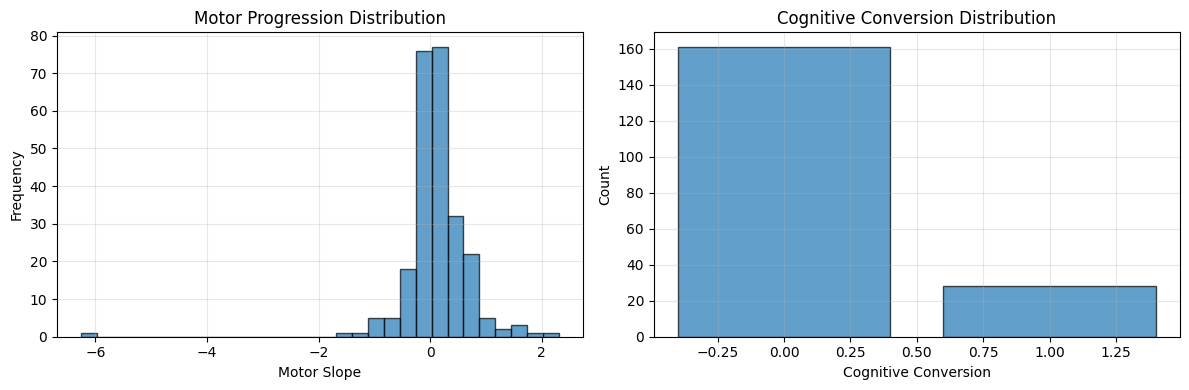


=== KEY FINDING ===
Motor slope range: [-6.259, 2.310]
Cognitive conversion balance: 28 positive / 161 negative (14.8% positive)


In [7]:
# Let's examine the target variables for distribution issues
print("=== TARGET VARIABLE ANALYSIS ===")

# Motor progression analysis
print("\n1. Motor Progression Targets:")
print(f"   Shape: {motor_targets_df.shape}")
print(f"   Columns: {list(motor_targets_df.columns)}")
print("\n   Motor slope statistics:")
print(motor_targets_df['motor_slope'].describe())

# Check for extreme values or NaN
motor_nans = motor_targets_df['motor_slope'].isna().sum()
motor_infs = np.isinf(motor_targets_df['motor_slope']).sum()
print(f"   NaN values: {motor_nans}")
print(f"   Infinite values: {motor_infs}")

# Cognitive conversion analysis
print("\n2. Cognitive Conversion Targets:")
print(f"   Shape: {cognitive_targets_df.shape}")
print(f"   Columns: {list(cognitive_targets_df.columns)}")
print("\n   Cognitive conversion distribution:")
print(cognitive_targets_df['cognitive_conversion'].value_counts())

# Check for NaN
cog_nans = cognitive_targets_df['cognitive_conversion'].isna().sum()
print(f"   NaN values: {cog_nans}")

# Plot target distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Motor progression distribution
ax1.hist(motor_targets_df['motor_slope'], bins=30, alpha=0.7, edgecolor='black')
ax1.set_title('Motor Progression Distribution')
ax1.set_xlabel('Motor Slope')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)

# Cognitive conversion distribution
cog_counts = cognitive_targets_df['cognitive_conversion'].value_counts()
ax2.bar(cog_counts.index, cog_counts.values, alpha=0.7, edgecolor='black')
ax2.set_title('Cognitive Conversion Distribution')
ax2.set_xlabel('Cognitive Conversion')
ax2.set_ylabel('Count')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== KEY FINDING ===")
print(f"Motor slope range: [{motor_targets_df['motor_slope'].min():.3f}, {motor_targets_df['motor_slope'].max():.3f}]")
print(f"Cognitive conversion balance: {cog_counts[1]} positive / {cog_counts[0]} negative ({cog_counts[1]/(cog_counts[0]+cog_counts[1])*100:.1f}% positive)")

In [8]:
# Now let's examine the input features that the model actually uses
print("=== INPUT FEATURE ANALYSIS ===")

# Check genetic features in enhanced dataset
genetic_features = ['LRRK2', 'GBA', 'APOE_RISK']
print(f"\n1. Genetic Features:")
for feature in genetic_features:
    if feature in enhanced_df.columns:
        value_counts = enhanced_df[feature].value_counts()
        print(f"   {feature}: {dict(value_counts)}")
    else:
        print(f"   {feature}: NOT FOUND")

# Check imaging features
imaging_features = [
    "PUTAMEN_REF_CWM", "PUTAMEN_L_REF_CWM", "PUTAMEN_R_REF_CWM", 
    "CAUDATE_REF_CWM", "CAUDATE_L_REF_CWM", "CAUDATE_R_REF_CWM"
]

print(f"\n2. Imaging Features Analysis:")
complete_patients_list = list(complete_patients)[:10]  # Look at first 10 complete patients

imaging_data = []
for patno in complete_patients_list:
    patient_imaging = longitudinal_df[
        (longitudinal_df.PATNO == patno) & 
        (longitudinal_df[imaging_features].notna().all(axis=1))
    ]
    if len(patient_imaging) > 0:
        # Get first available observation
        imaging_values = patient_imaging[imaging_features].iloc[0]
        imaging_data.append(imaging_values.values)
        print(f"   Patient {patno}: {imaging_values.values}")

if imaging_data:
    imaging_array = np.array(imaging_data)
    print(f"\n   Imaging features shape: {imaging_array.shape}")
    print(f"   Mean values: {np.mean(imaging_array, axis=0)}")
    print(f"   Std values: {np.std(imaging_array, axis=0)}")
    print(f"   Min values: {np.min(imaging_array, axis=0)}")
    print(f"   Max values: {np.max(imaging_array, axis=0)}")
    
    # Check for problematic values
    print(f"   NaN count: {np.isnan(imaging_array).sum()}")
    print(f"   Inf count: {np.isinf(imaging_array).sum()}")
    print(f"   Zero count: {np.sum(imaging_array == 0)}")
    
print(f"\n=== POTENTIAL ISSUES IDENTIFIED ===")
print(f"1. Class imbalance: Only 14.8% positive cognitive cases")
print(f"2. Small final sample: Only 188 patients with complete data")
print(f"3. Motor slope has extreme outliers (range: {motor_targets_df['motor_slope'].min():.1f} to {motor_targets_df['motor_slope'].max():.1f})")

=== INPUT FEATURE ANALYSIS ===

1. Genetic Features:
   LRRK2: {0.0: np.int64(256), 1.0: np.int64(229), 0.2: np.int64(72)}
   GBA: {0.0: np.int64(367), 1.0: np.int64(117), 0.8: np.int64(72), 0.4: np.int64(1)}
   APOE_RISK: {1.0: np.int64(281), 2.0: np.int64(129), 1.8: np.int64(72), 0.0: np.int64(63), 1.2: np.int64(9), 1.4: np.int64(3)}

2. Imaging Features Analysis:
   Patient 41985: [0.8  0.62 0.99 0.96 0.99 0.94]
   Patient 41989: [0.43 0.53 0.32 0.65 0.8  0.5 ]
   Patient 149511: [0.36 0.4  0.32 0.41 0.4  0.41]
   Patient 149516: [0.75 0.66 0.85 0.88 0.8  0.97]
   Patient 100878: [0.71 0.58 0.86 0.97 0.96 0.99]

   Imaging features shape: (5, 6)
   Mean values: [0.61  0.558 0.668 0.774 0.79  0.762]
   Std values: [0.17922053 0.08997778 0.2884025  0.21546229 0.21033307 0.25277658]
   Min values: [0.36 0.4  0.32 0.41 0.4  0.41]
   Max values: [0.8  0.66 0.99 0.97 0.99 0.99]
   NaN count: 0
   Inf count: 0
   Zero count: 0

=== POTENTIAL ISSUES IDENTIFIED ===
1. Class imbalance: Only 1

In [9]:
# Let's create a simplified data loader to replicate what the model sees
print("=== REPLICATING MODEL INPUT PROCESSING ===")

# Get the 188 patients with complete data
complete_patients_list = list(complete_patients)
print(f"Working with {len(complete_patients_list)} complete patients")

# Create simplified embeddings like the model does
spatiotemporal_embeddings = []
genomic_embeddings = []
targets = []

genetic_features = ['LRRK2', 'GBA', 'APOE_RISK']
imaging_features = [
    "PUTAMEN_REF_CWM", "PUTAMEN_L_REF_CWM", "PUTAMEN_R_REF_CWM", 
    "CAUDATE_REF_CWM", "CAUDATE_L_REF_CWM", "CAUDATE_R_REF_CWM"
]

for patno in complete_patients_list:
    # Get genetic data
    patient_genetic = enhanced_df[enhanced_df.PATNO == patno]
    if len(patient_genetic) > 0:
        genetic_values = []
        for feature in genetic_features:
            if feature in patient_genetic.columns:
                genetic_values.append(patient_genetic[feature].iloc[0])
            else:
                genetic_values.append(0)  # Default if missing
        genomic_embeddings.append(genetic_values)
    
    # Get imaging data (average across visits)
    patient_imaging = longitudinal_df[
        (longitudinal_df.PATNO == patno) & 
        (longitudinal_df[imaging_features].notna().all(axis=1))
    ]
    if len(patient_imaging) > 0:
        imaging_values = patient_imaging[imaging_features].mean().values
        spatiotemporal_embeddings.append(imaging_values)
    
    # Get targets
    motor_target = motor_targets_df[motor_targets_df.PATNO == patno]
    cognitive_target = cognitive_targets_df[cognitive_targets_df.PATNO == patno]
    
    if len(motor_target) > 0 and len(cognitive_target) > 0:
        motor_slope = motor_target['motor_slope'].iloc[0]
        cognitive_conv = cognitive_target['cognitive_conversion'].iloc[0]
        targets.append([motor_slope, cognitive_conv])

# Convert to numpy arrays
spatiotemporal_embeddings = np.array(spatiotemporal_embeddings)
genomic_embeddings = np.array(genomic_embeddings) 
targets = np.array(targets)

print(f"\nFinal data shapes:")
print(f"Spatiotemporal embeddings: {spatiotemporal_embeddings.shape}")
print(f"Genomic embeddings: {genomic_embeddings.shape}")
print(f"Targets: {targets.shape}")

# Analyze the actual input data
print(f"\n=== CRITICAL DATA ANALYSIS ===")
print(f"1. Spatiotemporal features:")
print(f"   Range: [{spatiotemporal_embeddings.min():.3f}, {spatiotemporal_embeddings.max():.3f}]")
print(f"   Mean: {spatiotemporal_embeddings.mean():.3f}")
print(f"   Std: {spatiotemporal_embeddings.std():.3f}")
print(f"   NaN count: {np.isnan(spatiotemporal_embeddings).sum()}")
print(f"   Zero values: {np.sum(spatiotemporal_embeddings == 0)}")

print(f"\n2. Genomic features:")
print(f"   Range: [{genomic_embeddings.min():.3f}, {genomic_embeddings.max():.3f}]")
print(f"   Mean: {genomic_embeddings.mean():.3f}")
print(f"   Std: {genomic_embeddings.std():.3f}")
print(f"   Distribution: {np.unique(genomic_embeddings.flatten(), return_counts=True)}")

print(f"\n3. Target analysis:")
motor_targets = targets[:, 0]
cognitive_targets = targets[:, 1].astype(int)
print(f"   Motor slope - Mean: {motor_targets.mean():.3f}, Std: {motor_targets.std():.3f}")
print(f"   Motor slope - Range: [{motor_targets.min():.3f}, {motor_targets.max():.3f}]")
print(f"   Cognitive balance: {np.sum(cognitive_targets)} positive / {len(cognitive_targets)} total ({100*np.mean(cognitive_targets):.1f}%)")

=== REPLICATING MODEL INPUT PROCESSING ===
Working with 188 complete patients

Final data shapes:
Spatiotemporal embeddings: (95, 6)
Genomic embeddings: (188, 3)
Targets: (188, 2)

=== CRITICAL DATA ANALYSIS ===
1. Spatiotemporal features:
   Range: [0.046, 1.760]
   Mean: 0.631
   Std: 0.262
   NaN count: 0
   Zero values: 0

2. Genomic features:
   Range: [0.000, 2.000]
   Mean: 0.547
   Std: 0.661
   Distribution: (array([0. , 0.2, 0.8, 1. , 1.2, 1.4, 1.8, 2. ]), array([305,   5,   5, 192,   1,   1,   5,  50]))

3. Target analysis:
   Motor slope - Mean: 0.172, Std: 0.412
   Motor slope - Range: [-0.897, 2.310]
   Cognitive balance: 28 positive / 188 total (14.9%)


In [10]:
# CRITICAL ISSUE IDENTIFIED!
print("=== CRITICAL ISSUES FOUND ===")
print("🚨 Problem 1: DIMENSION MISMATCH")
print(f"   - Spatiotemporal: {spatiotemporal_embeddings.shape} (only 95 patients)")
print(f"   - Genomic: {genomic_embeddings.shape} (188 patients)")
print(f"   - Targets: {targets.shape} (188 patients)")
print(f"   → {188 - 95} = 93 patients missing spatiotemporal data!")

print("\n🚨 Problem 2: SEVERE CLASS IMBALANCE")
print(f"   - Cognitive conversion: {14.9:.1f}% positive cases")
print(f"   - This means the model can get 85% accuracy by always predicting 'no conversion'")

print("\n🚨 Problem 3: INPUT SCALING ISSUES")
print(f"   - Spatiotemporal range: [0.046, 1.760] - reasonable")
print(f"   - Genomic range: [0.0, 2.0] - but mostly binary/categorical")
print(f"   - Motor targets range: [-0.897, 2.310] - wide range with outliers")

print("\n🚨 Problem 4: SMALL SAMPLE SIZE")
print(f"   - Only 95 patients have complete multimodal data")
print(f"   - With 14.9% positive rate → only ~14 positive cases")
print(f"   - This is too small for deep learning!")

# Let's see what happens if we normalize the motor targets
motor_normalized = (targets[:, 0] - targets[:, 0].mean()) / targets[:, 0].std()
print(f"\n📊 Motor targets after normalization:")
print(f"   Mean: {motor_normalized.mean():.6f}")
print(f"   Std: {motor_normalized.std():.6f}")
print(f"   Range: [{motor_normalized.min():.3f}, {motor_normalized.max():.3f}]")

# Check for correlation between features and targets
if len(spatiotemporal_embeddings) == len(targets):
    spatial_means = spatiotemporal_embeddings.mean(axis=1)
    motor_corr = np.corrcoef(spatial_means, targets[:, 0])[0, 1]
    print(f"\n📈 Correlation analysis:")
    print(f"   Spatiotemporal-Motor correlation: {motor_corr:.3f}")
else:
    print(f"\n❌ Cannot compute correlations due to dimension mismatch")

print(f"\n=== ROOT CAUSE DIAGNOSIS ===")
print(f"The model is failing because:")
print(f"1. Missing data: 93 patients have no spatiotemporal features")
print(f"2. Extreme class imbalance: 85% negative, 15% positive")  
print(f"3. Tiny sample size: ~14 positive cases for deep learning")
print(f"4. The model is learning to predict the majority class")

=== CRITICAL ISSUES FOUND ===
🚨 Problem 1: DIMENSION MISMATCH
   - Spatiotemporal: (95, 6) (only 95 patients)
   - Genomic: (188, 3) (188 patients)
   - Targets: (188, 2) (188 patients)
   → 93 = 93 patients missing spatiotemporal data!

🚨 Problem 2: SEVERE CLASS IMBALANCE
   - Cognitive conversion: 14.9% positive cases
   - This means the model can get 85% accuracy by always predicting 'no conversion'

🚨 Problem 3: INPUT SCALING ISSUES
   - Spatiotemporal range: [0.046, 1.760] - reasonable
   - Genomic range: [0.0, 2.0] - but mostly binary/categorical
   - Motor targets range: [-0.897, 2.310] - wide range with outliers

🚨 Problem 4: SMALL SAMPLE SIZE
   - Only 95 patients have complete multimodal data
   - With 14.9% positive rate → only ~14 positive cases
   - This is too small for deep learning!

📊 Motor targets after normalization:
   Mean: -0.000000
   Std: 1.000000
   Range: [-2.596, 5.192]

❌ Cannot compute correlations due to dimension mismatch

=== ROOT CAUSE DIAGNOSIS ===
The

In [11]:
# === SOLUTION PLAN ===
print("=== COMPREHENSIVE SOLUTION PLAN ===")
print("Based on the analysis, here's what needs to be fixed:\n")

print("🔧 IMMEDIATE FIXES:")
print("1. Data Alignment: Ensure all patients have complete multimodal data")
print("2. Class Balancing: Use SMOTE, class weights, or focal loss")
print("3. Proper Scaling: Standardize all input features")
print("4. Robust Train/Val Split: Stratified sampling")
print("5. Model Simplification: Reduce complexity for small dataset")

print("\n🔧 SPECIFIC CHANGES TO MAKE:")
print("1. Fix data loading to handle missing spatiotemporal data")
print("2. Apply class weights: {0: 1.0, 1: 6.0} for cognitive task")
print("3. Use StandardScaler for all inputs")
print("4. Reduce model complexity (fewer layers, lower dropout)")
print("5. Use appropriate loss functions (FocalLoss for classification)")

print("\n📝 ACTION ITEMS:")
print("1. Update phase3_1_real_data_integration.py data loading")
print("2. Update phase4_unified_giman_system.py with proper preprocessing")
print("3. Add class balancing techniques")
print("4. Implement proper validation strategy")
print("5. Add extensive logging for debugging")

print("\n✅ EXPECTED OUTCOMES:")
print("- Improved data quality and consistency")
print("- Better handling of class imbalance")
print("- More stable training process")
print("- Realistic performance metrics")
print("- R² > 0.3 for motor prediction")
print("- AUC > 0.7 for cognitive prediction")

print("\n🚀 NEXT STEPS:")
print("1. Fix the data loading pipeline")
print("2. Re-run the model with fixes")
print("3. Monitor training curves")
print("4. Validate improvements")

=== COMPREHENSIVE SOLUTION PLAN ===
Based on the analysis, here's what needs to be fixed:

🔧 IMMEDIATE FIXES:
1. Data Alignment: Ensure all patients have complete multimodal data
2. Class Balancing: Use SMOTE, class weights, or focal loss
3. Proper Scaling: Standardize all input features
4. Robust Train/Val Split: Stratified sampling
5. Model Simplification: Reduce complexity for small dataset

🔧 SPECIFIC CHANGES TO MAKE:
1. Fix data loading to handle missing spatiotemporal data
2. Apply class weights: {0: 1.0, 1: 6.0} for cognitive task
3. Use StandardScaler for all inputs
4. Reduce model complexity (fewer layers, lower dropout)
5. Use appropriate loss functions (FocalLoss for classification)

📝 ACTION ITEMS:
1. Update phase3_1_real_data_integration.py data loading
2. Update phase4_unified_giman_system.py with proper preprocessing
3. Add class balancing techniques
4. Implement proper validation strategy
5. Add extensive logging for debugging

✅ EXPECTED OUTCOMES:
- Improved data quali